# Student Name: Murali Krishnan Rajasekharan Pillai
# ECE 595 Machine Learning II
# Bonus Exercise : Visualizing the Percent Activating Units in Hidden Layers

In [1]:
!nvidia-smi

Fri Oct  4 19:13:16 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
MODEL_LOCATION = "gdrive/My Drive/ece595_ml2/models/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D
from keras.optimizers import Adam
from keras import backend as K
import matplotlib.pyplot as plt
import pickle

Using TensorFlow backend.


# Part 0 : Importing and Normalizing MNIST Data

In [5]:
# has shape (num_samples, 28, 28)
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = data_train / 255.0
data_test = data_test / 255.0
data_train = data_train.reshape(60000, 28, 28, 1)
data_test = data_test.reshape(10000, 28, 28, 1)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Create labels as one-hot encoders
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.np_utils.to_categorical(labels_test, num_classes=10)

# Defining a CNN

In [0]:
class model_methods(object):
  def __init__(self, loss_fn, optim, ndim):
    """
    Try to develop a class which contains common functionality of
    NN models. Like saving a model & it's weights."""
    self.loss_fn = loss_fn
    self.optim = optim
    self.ndim = ndim
  
  def save_model_weights(self, h5_file_name):
    """
    Save weights of the model
    Parameters:
      :h5_file_name:    Identifier of the model weights h5 file
    """
    self.model.save_weights(h5_file_name)
  
  def save_model(self, json_file_name):
    """
    Save the model
    Parameters:
      :json_file_name:    Identifier of the model in json file
    """
    ae_model_json = self.model.to_json()
    with open(json_file_name, 'w') as json_file:
      json_file.write(ae_model_json)
  
  def load_model(self, json_file_name, h5_file_name):
    json_file = open(MODEL_LOCATION + json_file_name, 'r')
    loaded_from_json = json_file.read()
    json_file.close()
    ae_model = model_from_json(loaded_from_json) 
    ae_model.load_weights(MODEL_LOCATION + h5_file_name)
    return ae_model

  def save_model_history(self, model_history, file_name):
    """
    Save model history as a pickle file
    """
    with open(file_name, 'wb') as f:
      pickle.dump(model_history, f)

  def load_model_history(self, pkl_file_name):
    """
    Load model history pickle file
    """
    with open(MODEL_LOCATION + pkl_file_name , 'rb') as f:
      ae_history = pickle.load(f)
    return ae_history


In [0]:
class CNN_model(model_methods):
  def __init__(self, loss_fn, optim, ndim, num_classes):
    super().__init__(loss_fn, optim, ndim)
    self.num_classes = num_classes
    self.model = self._build_model()

  
  def _build_model(self):
    """
    Defines and compiles the architecture
    Parameters:
      :loss_fn:    The loss function used in the model
      :optim:      The optimizer used for model
    Returns:
      :model:  The compiled model
    """
    model = Sequential()
    model.add(Conv2D(16,
                     (3, 3),
                     activation='relu',
                     padding='same',
                     input_shape=(self.ndim, self.ndim, 1)))
    model.add(Dropout(0.30))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(8,
                     (3, 3),
                     padding='same',
                     activation='relu'))
    model.add(Dropout(0.30))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(50,
                    activation='relu',
                    kernel_initializer='normal'))
    model.add(Dense(50,
                    activation='relu',
                    kernel_initializer='normal'))
    model.add(Dense(self.num_classes,
                    activation='softmax'))
    model.compile(loss=self.loss_fn,
                  optimizer=self.optim,
                  metrics=['accuracy'])
    return model
    
  def fit(self, d_train, d_test, 
          n_epochs=100, 
          batch_size=50,
          display=25):
    """
      Fit the model

      Parameters:
        :d_train:    Tuple of (training data, training labels)
        :d_test:     Tuple of (testing data, testing labels)
        :n_epochs:   Number of epochs for fit
        :batch_size: Number of samples per gradient update
      Returns:
        :model_history: History object containing all model history info

    """
    data_train, labels_train = d_train
    #out_batch = NBatchLogger(display)
    model_history = self.model.fit(data_train, labels_train,
                          validation_data=d_test,
                          epochs=n_epochs,
                          batch_size=batch_size,
                          shuffle=True)
    return model_history

In [9]:
cnn = CNN_model('categorical_crossentropy', 'adam', 28, 10)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





In [10]:
cnn_history = cnn.fit((data_train, labels_train),
                    (data_test, labels_test),
                    n_epochs=150,
                    batch_size=1024)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 10s 165us/step - loss: 1.3533 - acc: 0.6072 - val_loss: 0.6247 - val_acc: 0.8424
Epoch 2/150
60000/60000 [==============================] - 2s 39us/step - loss: 0.3714 - acc: 0.8850 - val_loss: 0.3744 - val_acc: 0.9242
Epoch 3/150
60000/60000 [==============================] - 2s 39us/step - loss: 0.2537 - acc: 0.9228 - val_loss: 0.2783 - val_acc: 0.9461
Epoch 4/150
60000/60000 [==============================] - 2s 39us/step - loss: 0.1958 - acc: 0.9389 - val_loss: 0.2324 - val_acc: 0.9542
Epoch 5/150
60000/60000 [==============================] - 2s 40us/step - loss: 0.1552 - acc: 0.9527 - val_loss: 0.1899 - val_acc: 0.9644
Epoch 6/150
60000/60000 [==============================] - 2s 39us/step - loss: 0.1350 - acc: 0.9579 - val_loss: 0.1606 - val_acc: 0.9677
Epoch 7/150
60000/60000 [=

In [0]:
cnn.save_model_weights("bonus_cnn_model_weights.h5")
cnn.save_model("bonus_cnn_model.json")
cnn.save_model_history(cnn_history, "bonus_cnn_model_history.pkl")

In [0]:
! cp -r bonus_cnn_model.json bonus_cnn_model_weights.h5 bonus_cnn_model_history.pkl ./gdrive/My\ Drive/ece595_ml2/models/

In [0]:
cnn_model = cnn.load_model("bonus_cnn_model.json", "bonus_cnn_model_weights.h5")

In [0]:
cnn_reconstructions = cnn_model.predict(data_test)

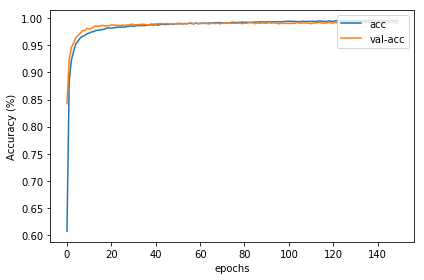

In [15]:
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.legend(['acc', 'val-acc'], loc='upper right')
plt.xlabel("epochs")
plt.ylabel(r"Accuracy (%)")
plt.tight_layout()
plt.show()

In [16]:
print(len(cnn_model.layers))
print(cnn_model.summary())

10
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)           

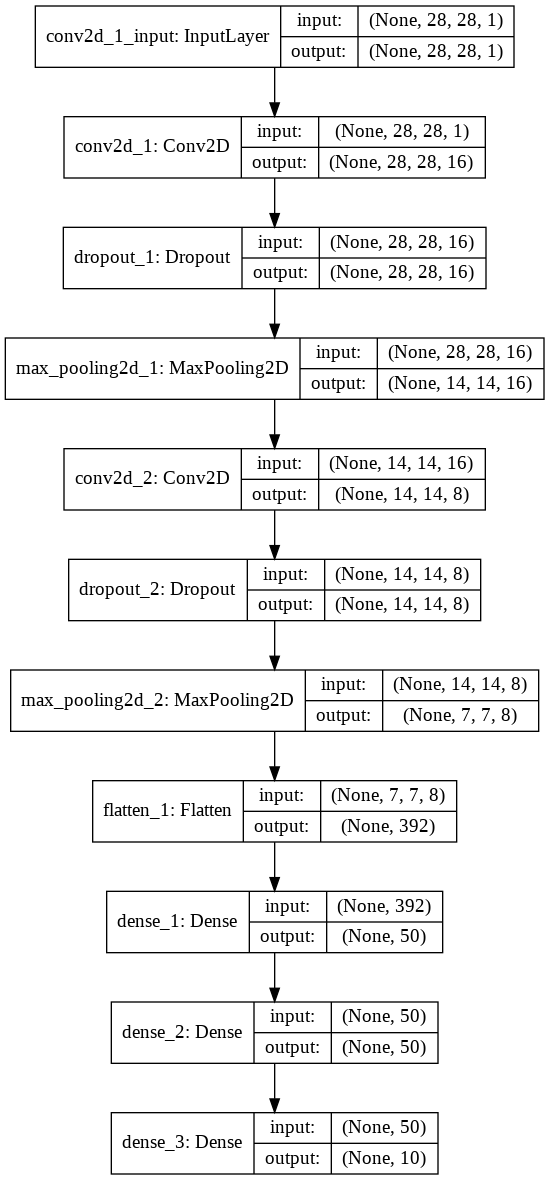

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
conv2d_1 = K.function([cnn_model.layers[0].input], [cnn_model.layers[0].output])
conv2d_2 = K.function([cnn_model.layers[0].input], [cnn_model.layers[3].output])
dense_1 = K.function([cnn_model.layers[0].input], [cnn_model.layers[7].output])
dense_2 = K.function([cnn_model.layers[0].input], [cnn_model.layers[8].output])
dense_3 = K.function([cnn_model.layers[0].input], [cnn_model.layers[9].output])

In [26]:
units = conv2d_1([data_test])[0].flatten()
print(units.shape)

(125440000,)


In [0]:
def count_active_units(layer_function):
  """
    Count the number of active/inactive units in a layer
    Parameters:
      layer_function: 
  """
  units = layer_function([data_test])[0].flatten()
  total_units = units.shape[0]
  non_zero = np.count_nonzero(units)
  return [total_units, non_zero]

In [0]:
non_zero = []
total = []
for layer in [conv2d_1, conv2d_2, dense_1, dense_2, dense_3]:
  temp_tot, temp_nz = count_active_units(layer)
  non_zero.append(temp_nz)
  total.append(temp_tot)

In [41]:
zero = [i - j for i, j in zip(total, non_zero)]
ratios = [100 * (i-j) / i for i, j in zip(total, non_zero)]
print(zero)

[74510928, 10171293, 225561, 206053, 0]


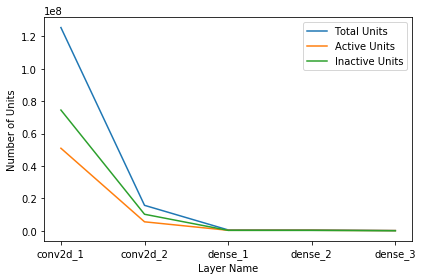

In [48]:
n_layers = len(zero)
n = ['conv2d_1', 'conv2d_2', 'dense_1', 'dense_2', 'dense_3']
fig, ax = plt.subplots()
ax.plot(n, total, label='Total Units')
ax.plot(n, non_zero, label='Active Units')
ax.plot(n, zero, label='Inactive Units')
ax.legend(loc='upper right')
ax.set_ylabel("Number of Units")
fig.tight_layout()
plt.show()

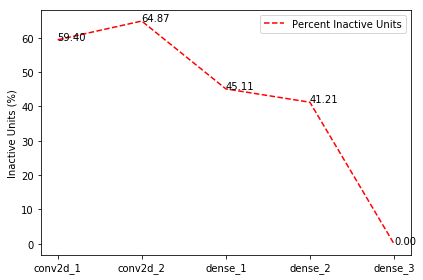

In [61]:
n_layers = len(zero)
n = ['conv2d_1', 'conv2d_2', 'dense_1', 'dense_2', 'dense_3']
fig, ax = plt.subplots()
ax.plot(n, ratios, 'r--',
         label="Percent Inactive Units")
for i, j in zip(n, ratios):
  label = "{:.2f}".format(j)
  ax.annotate(label ,xy = (i,j))
ax.legend(loc='upper right')
ax.set_ylabel(r"Inactive Units (%)")
fig.tight_layout()
plt.show()